In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
import matplotlib.pyplot as plt, matplotlib
import numpy as np, healpy as hp, h5py
from scipy import stats, special, linalg, optimize
import emcee, tqdm, corner

from pylab import cm

In [368]:
# Plotting modules
import matplotlib
from pylab import cm
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
plt.rc('text', usetex=True)
plt.rc('font', family='serif')
plt.rc('axes', labelsize=16)
plt.rc('xtick',labelsize=16)
plt.rc('ytick',labelsize=16)
plt.rc('legend',fontsize=16)
plt.rc('font',size=16)

## Load data

In [395]:
nside=128
def downsize(arr, nbig, nsmall):
    return np.sum(np.reshape(arr, (-1,int((nbig/nsmall)**2+0.1))), axis=1)
def logit(p):
    return np.log(p/(1-p))
def expit(x):
    return 1/(1+np.exp(-x))
n2r = hp.ring2nest(nside, np.arange(hp.nside2npix(nside)))

In [392]:
data = {}
mag = 20.
with h5py.File('/data/asfe2/Projects/astrometry/gaia3_astcounts_hpx10.h', 'r') as hf:
    magid = np.argwhere(hf['magval'][...]==mag)[0,0]
    data['n'] = np.zeros(hp.nside2npix(128)).astype(int)
    data['n'][hf[str(magid)]['hpx'][...]] = hf[str(magid)]['n'][...]
    data['n'] = downsize(data['n'], 128, nside)[n2r]
    data['k'] = np.zeros(hp.nside2npix(128)).astype(int)
    data['k'][hf[str(magid)]['hpx'][...]] = hf[str(magid)]['k_ast'][...]
    data['k'] = downsize(data['k'], 128, nside)[n2r]

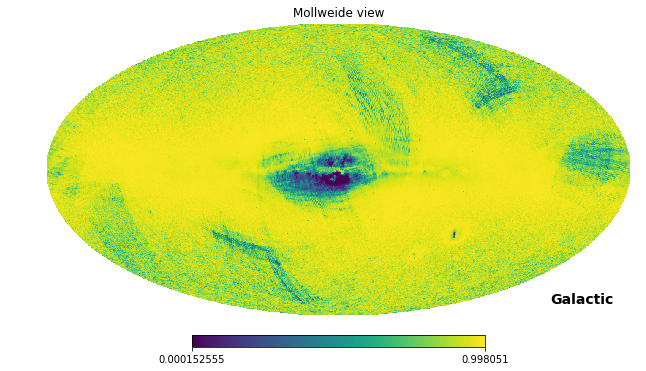

In [297]:
p = (data['k']+1)/(data['n']+2)
hp.mollview(x, coord=['C','G'])

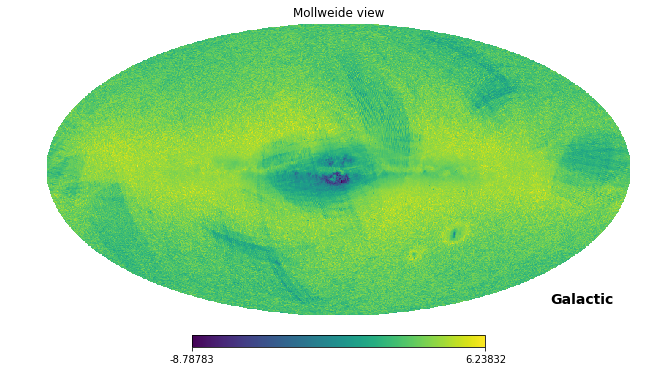

In [309]:
x = logit((data['k']+1)/(data['n']+2))
hp.mollview(x, coord=['C','G'])

## Spherical harmonic - wavelet transform

In [306]:
lmax = [10,30,100]

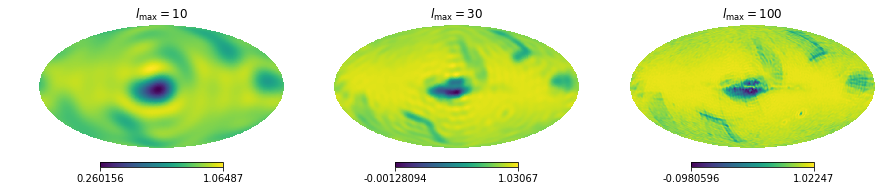

In [307]:
fig, ax = plt.subplots(1,len(lmax), figsize=(5*len(lmax), 5))
for i in range(len(lmax)):
    plt.sca(ax[i])
    alm_map = hp.map2alm((data['k']+1)/(data['n']+2), lmax=lmax[i])
    _map = hp.alm2map(alm_map, nside, verbose=False)
    hp.mollview(_map, coord=['C','G'], hold=True, notext=True, title=r'$l_\mathrm{max} = %d$'%lmax[i])

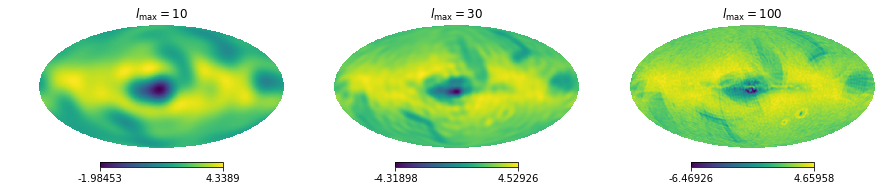

In [312]:
fig, ax = plt.subplots(1,len(lmax), figsize=(5*len(lmax), 5))
for i in range(len(lmax)):
    plt.sca(ax[i])
    alm_map = hp.map2alm(x, lmax=lmax[i])
    _map = hp.alm2map(alm_map, nside, verbose=False)
    hp.mollview(_map, coord=['C','G'], hold=True, notext=True, title=r'$l_\mathrm{max} = %d$'%lmax[i])

### Power spectrum

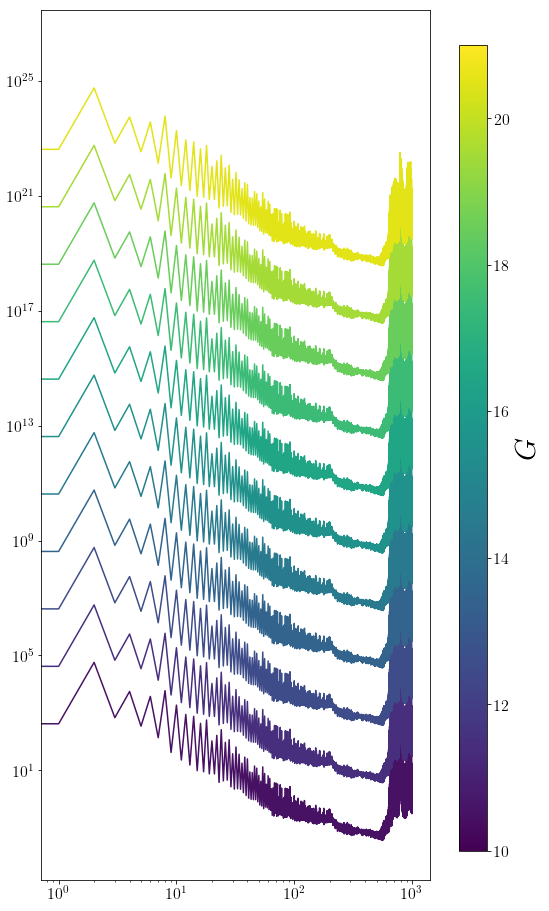

In [386]:
fig = plt.figure(figsize=(8,16))

cmap = cm.viridis; mmin=10.; mmax=21.

lmax=1000
for i, mag in enumerate(np.arange(10.5,21.,1.)):
        
    x = logit((data['k']+1)/(data['n']+2))
        
    spectrum = hp.anafast(x, lmax=lmax) * 10**(2*i)
    plt.plot(np.arange(lmax+1), spectrum, color=cmap((mag-mmin)/(mmax-mmin)))
    #plt.plot(np.repeat(np.arange(lmax+2),2)[1:-1]-0.5, np.repeat(spectrum,2), color=cmap((mag-mmin)/(mmax-mmin)))
plt.yscale('log'); plt.xscale('log')
    
# Adding cbar axes to subplots
fig.subplots_adjust(right=0.8)
cbar_ax = fig.add_axes([0.85, 0.15, 0.05, 0.7])
norm = matplotlib.colors.Normalize(vmin=mmin,vmax=mmax)
im = plt.cm.ScalarMappable(norm=norm, cmap='viridis')
im.set_array([])
cbar = fig.colorbar(im, cax=cbar_ax)
cbar.set_label(r'$G$', fontsize=30)

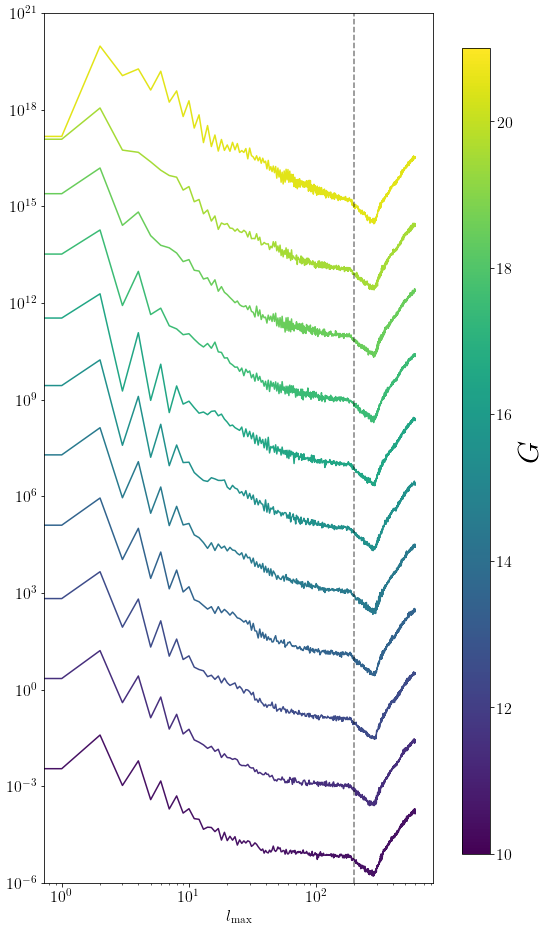

In [388]:
fig = plt.figure(figsize=(8,16))

cmap = cm.viridis; mmin=10.; mmax=21.

lmax=600
for i, mag in enumerate(np.arange(10.5,21.,1.)):
        
    with h5py.File('/data/asfe2/Projects/astrometry/gaia3_astcounts.h', 'r') as hf:
        magid = np.argwhere(hf['magval'][...]==mag)[0,0]
        n_sample = np.zeros(hp.nside2npix(128))
        n_sample[hf[str(magid)]['hpx'][...]] = hf[str(magid)]['n'][...]
        n_sample = downsize(n_sample, 128, nside)[n2r]
        k_sample = np.zeros(hp.nside2npix(128))
        k_sample[hf[str(magid)]['hpx'][...]] = hf[str(magid)]['k'][...]
        k_sample = downsize(k_sample, 128, nside)[n2r]
        
    x = logit((k_sample+1)/(n_sample+2))
        
    spectrum = hp.anafast(x, lmax=lmax) * 10**(2*i)
    plt.plot(np.arange(lmax+1), spectrum, color=cmap((mag-mmin)/(mmax-mmin)))
    #plt.plot(np.repeat(np.arange(lmax+2),2)[1:-1]-0.5, np.repeat(spectrum,2), color=cmap((mag-mmin)/(mmax-mmin)))
plt.yscale('log'); plt.xscale('log'); plt.xlabel(r'$l_\mathrm{max}$')
plt.ylim(1e-6, 1e21)

plt.plot([200,200],[1e-6,1e21],'--k', alpha=0.5)

# Adding cbar axes to subplots
fig.subplots_adjust(right=0.8)
cbar_ax = fig.add_axes([0.85, 0.15, 0.05, 0.7])
norm = matplotlib.colors.Normalize(vmin=mmin,vmax=mmax)
im = plt.cm.ScalarMappable(norm=norm, cmap='viridis')
im.set_array([])
cbar = fig.colorbar(im, cax=cbar_ax)
cbar.set_label(r'$G$', fontsize=30)

plt.savefig('figs/powerspectrum_betamean_ast_nside%d.png' % nside, bbox_inches='tight')

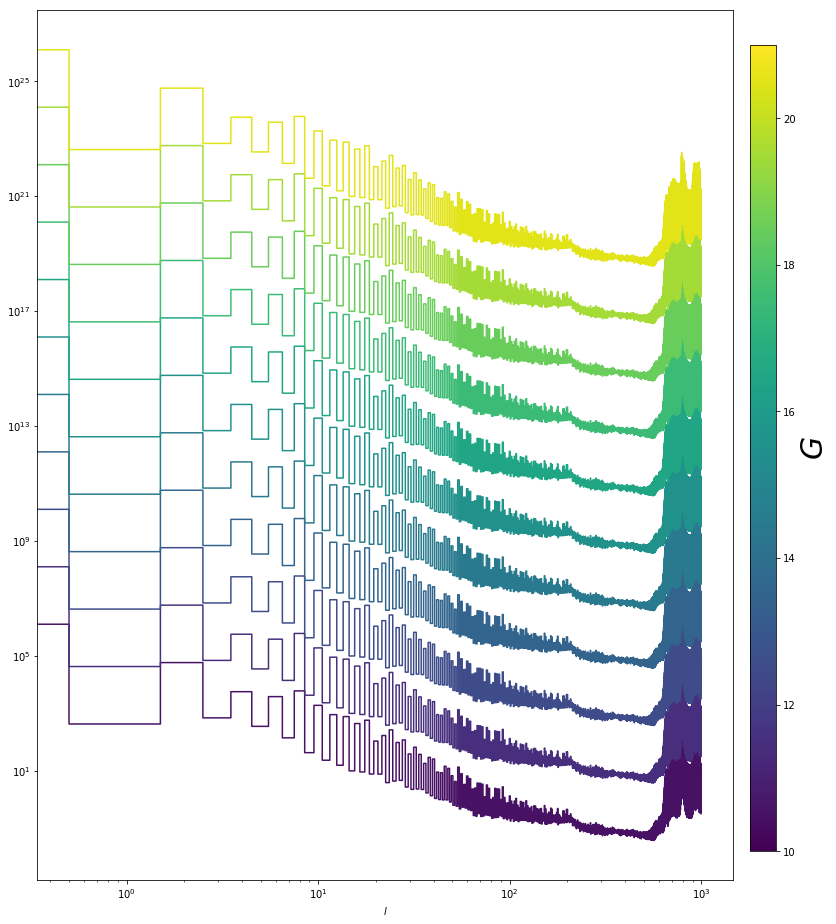

In [317]:
fig = plt.figure(figsize=(12,16))

cmap = cm.viridis; mmin=10.; mmax=21.

lmax=1000
for i, mag in enumerate(np.arange(10.5,21.,1.)):
        
    x = logit((data['k']+1)/(data['n']+2))
        
    spectrum = hp.anafast(x, lmax=lmax) * 10**(2*i)
    plt.plot(np.repeat(np.arange(lmax+2),2)[1:-1]-0.5, np.repeat(spectrum,2),
                color=cmap((mag-mmin)/(mmax-mmin)))
plt.yscale('log'); plt.xscale('log')
plt.xlabel(r'$l$')

# Adding cbar axes to subplots
fig.subplots_adjust(right=0.93)
cbar_ax = fig.add_axes([0.95, 0.15, 0.03, 0.7])
norm = matplotlib.colors.Normalize(vmin=mmin,vmax=mmax)
im = plt.cm.ScalarMappable(norm=norm, cmap='viridis')
im.set_array([])
cbar = fig.colorbar(im, cax=cbar_ax)
cbar.set_label(r'$G$', fontsize=30)

## Source density power spectrum

/home/andy/py3/lib/python3.5/site-packages/ipykernel_launcher.py:12: RuntimeWarning: divide by zero encountered in log
  if sys.path[0] == '':


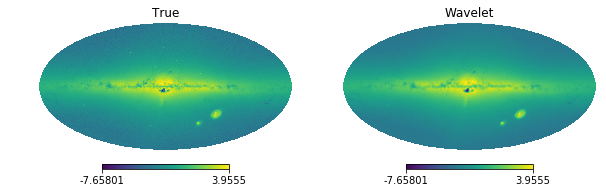

In [16]:
lmax=100

data = {}
with h5py.File('/data/asfe2/Projects/astrometry/gaia3_astcounts.h', 'r') as hf:
    magid = np.argwhere(hf['magval'][...]==mag)[0,0]
    data['n'] = np.zeros(hp.nside2npix(128))
    data['n'][hf[str(magid)]['hpx'][...]] = hf[str(magid)]['n'][...]
    data['n'] = downsize(data['n'], 128, nside)[n2r]


n_mean = np.sum(data['n'])/hp.nside2npix(nside)
x = np.where((data['n']>0), np.log(data['n']/n_mean),
                            -10)

fig, ax = plt.subplots(1,2, figsize=(10, 5))

plt.sca(ax[1])
alm_map = hp.map2alm(x, lmax=lmax)
_map = hp.alm2map(alm_map, nside, verbose=False)
hp.mollview(_map, coord=['C','G'], hold=True, notext=True, title='Wavelet')

plt.sca(ax[0])
hp.mollview(x, coord=['C','G'], hold=True, notext=True, title='True', min=np.min(_map), max=np.max(_map))

/home/andy/py3/lib/python3.5/site-packages/ipykernel_launcher.py:17: RuntimeWarning: divide by zero encountered in log


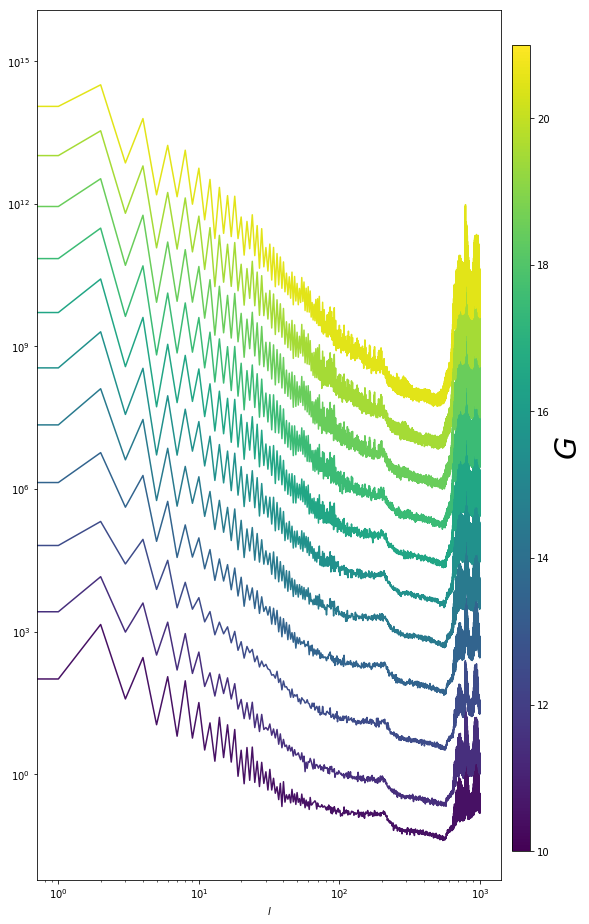

In [17]:
fig = plt.figure(figsize=(8,16))

cmap = cm.viridis; mmin=10.; mmax=21.

lmax=1000
for i, mag in enumerate(np.arange(10.5,21.,1.)):

    data = {}
    with h5py.File('/data/asfe2/Projects/astrometry/gaia3_astcounts.h', 'r') as hf:
        magid = np.argwhere(hf['magval'][...]==mag)[0,0]
        data['n'] = np.zeros(hp.nside2npix(128))
        data['n'][hf[str(magid)]['hpx'][...]] = hf[str(magid)]['n'][...]
        data['n'] = downsize(data['n'], 128, nside)[n2r]
        
        
    n_mean = np.sum(data['n'])/hp.nside2npix(nside)
    x = np.where((data['n']>0), np.log(data['n']/n_mean), 0)
        
    spectrum = hp.anafast(x, lmax=lmax) * 10**(i)
    plt.plot(np.arange(lmax+1), spectrum, color=cmap((mag-mmin)/(mmax-mmin)))
plt.yscale('log'); plt.xscale('log')
plt.xlabel(r'$l$')

# Adding cbar axes to subplots
fig.subplots_adjust(right=0.93)
cbar_ax = fig.add_axes([0.95, 0.15, 0.03, 0.7])
norm = matplotlib.colors.Normalize(vmin=mmin,vmax=mmax)
im = plt.cm.ScalarMappable(norm=norm, cmap='viridis')
im.set_array([])
cbar = fig.colorbar(im, cax=cbar_ax)
cbar.set_label(r'$G$', fontsize=30)

/home/andy/py3/lib/python3.5/site-packages/ipykernel_launcher.py:17: RuntimeWarning: divide by zero encountered in log


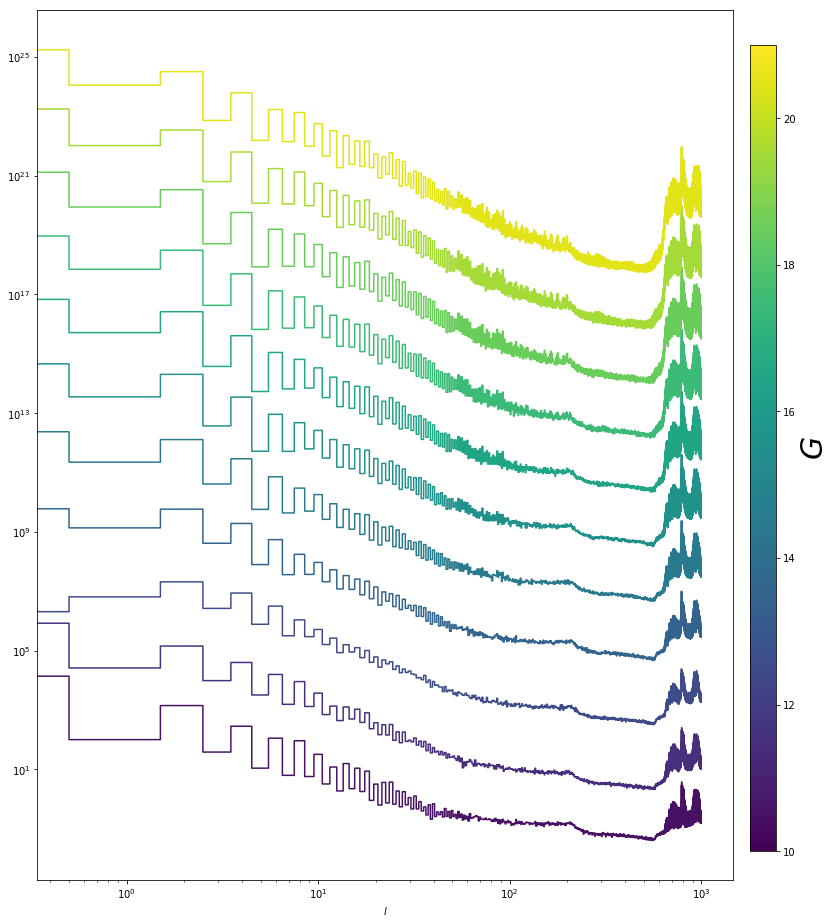

In [146]:
fig = plt.figure(figsize=(12,16))

cmap = cm.viridis; mmin=10.; mmax=21.

lmax=1000
for i, mag in enumerate(np.arange(10.5,21.,1.)):

    data = {}
    with h5py.File('/data/asfe2/Projects/astrometry/gaia3_astcounts.h', 'r') as hf:
        magid = np.argwhere(hf['magval'][...]==mag)[0,0]
        data['n'] = np.zeros(hp.nside2npix(128))
        data['n'][hf[str(magid)]['hpx'][...]] = hf[str(magid)]['n'][...]
        data['n'] = downsize(data['n'], 128, nside)[n2r]
        
        
    n_mean = np.sum(data['n'])/hp.nside2npix(nside)
    x = np.where((data['n']>0), np.log(data['n']/n_mean),
                                0)
        
    spectrum = hp.anafast(x, lmax=lmax) * 10**(2*i)
    plt.plot(np.repeat(np.arange(lmax+2),2)[1:-1]-0.5, np.repeat(spectrum,2),
                color=cmap((mag-mmin)/(mmax-mmin)))
plt.yscale('log'); plt.xscale('log')
plt.xlabel(r'$l$')

# Adding cbar axes to subplots
fig.subplots_adjust(right=0.93)
cbar_ax = fig.add_axes([0.95, 0.15, 0.03, 0.7])
norm = matplotlib.colors.Normalize(vmin=mmin,vmax=mmax)
im = plt.cm.ScalarMappable(norm=norm, cmap='viridis')
im.set_array([])
cbar = fig.colorbar(im, cax=cbar_ax)
cbar.set_label(r'$G$', fontsize=30)

# Try again with Beta distribution

In [372]:
alpha = data['k']+1
beta = data['n']-data['k']+1

In [393]:
sample = scipy.stats.beta.rvs(alpha, beta, size=len(alpha))

pvals = scipy.stats.beta.cdf(sample, alpha, beta)
#pvals_mean = np.unique(scipy.stats.beta.cdf(alpha/(alpha+beta), alpha, beta))

In [403]:
np.max(_map)

3398.4246784779507

In [406]:
lmaxs = [10,30,100,300]
pvals_lmax = np.zeros((len(lmaxs), len(data['k'])))

integral = np.zeros((len(lmaxs), len(data['k'])))
for j in tqdm.tqdm_notebook(range(len(lmaxs))):
    alm_map = hp.map2alm(logit(sample), lmax=lmaxs[j])
    _map = hp.alm2map(alm_map, nside, verbose=False)

    pvals_lmax[j] = scipy.stats.beta.cdf(expit(_map), alpha, beta)

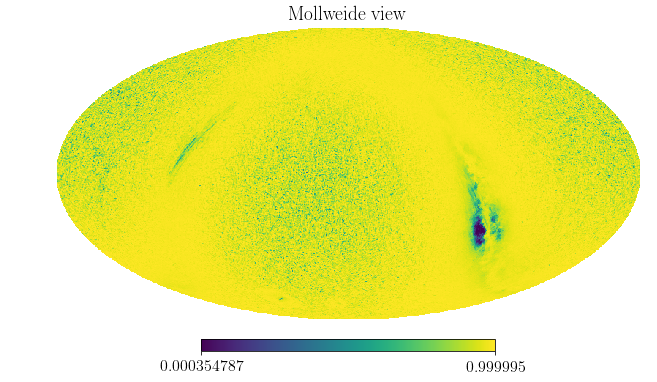

In [442]:
lmax=500
alm_map = hp.map2alm(logit(sample), lmax=lmax)
_map = hp.alm2map(alm_map, nside, verbose=False)
hp.mollview(expit(_map))

plt.savefig('figs/lmax%d_nside%d.png' % (lmax,nside), bbox_inches='tight')

In [427]:
_map

array([-4331.39755269, -4225.91329913, -3126.69202721, ...,
       -3990.06475449, -3759.7798747 , -3390.80937836])

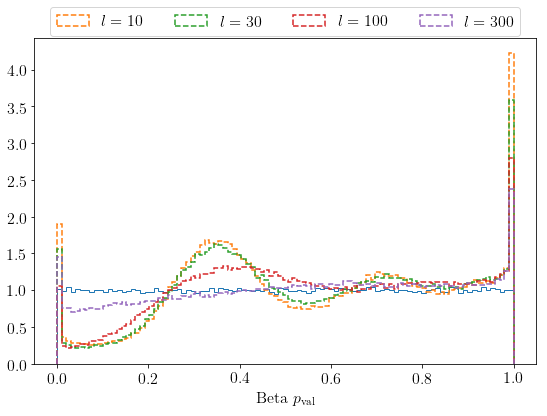

In [436]:
plt.figure(figsize=(9,6))

bins=np.linspace(0,1,100)
plt.hist(pvals, bins=bins, histtype='step', density=True);
#plt.hist(pvals_mean, bins=bins, histtype='step', density=True);

for j in range(len(lmaxs)):
    plt.hist(pvals_lmax[j], bins=bins, histtype='step', label=r'$l=%d$'%lmaxs[j], density=True, 
             linewidth=1.5, linestyle='--');
plt.legend(loc='upper center', ncol=len(lmaxs), bbox_to_anchor=(0.5,1.12))
#plt.yscale('log')

plt.xlabel(r'Beta $p_\mathrm{val}$')

plt.savefig('figs/BetaPval-test_ast_nside%d.png' % nside, bbox_inches='tight')

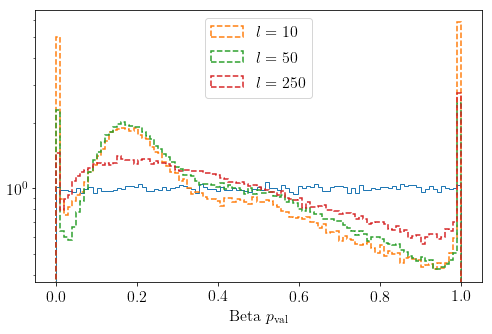

In [383]:
plt.figure(figsize=(8,5))

bins=np.linspace(0,1,100)
plt.hist(pvals, bins=bins, histtype='step', density=True);
#plt.hist(pvals_mean, bins=bins, histtype='step', density=True);

bins=np.linspace(0,1,100)
for j in range(len(lmaxs)):
    plt.hist(pvals_lmax[j], bins=bins, histtype='step', label=r'$l=%d$'%lmaxs[j], density=True, 
             linewidth=1.5, linestyle='--');
plt.legend(loc='upper center')
plt.yscale('log')

plt.xlabel(r'Beta $p_\mathrm{val}$')


plt.savefig('figs/BetaPval-test_ast_nside%d.png' % nside, bbox_inches='tight')

# Test Resolution

In [88]:
def binomial(x, k, n):
    comb=np.math.factorial(n+1)/(np.math.factorial(k)*np.math.factorial(n-k))
    return comb * x**k * (1-x)**(n-k)

In [272]:
def lnbinomial(p, k, n):
    comb=fact_grid[n+1] - fact_grid[k] - fact_grid[n-k]
    return comb + k*np.log(p) + (n-k)*np.log(1-p)

In [283]:
fact_grid = np.insert(np.cumsum(np.log(np.arange(1, np.max(data['n'].astype(int))+2))), 0,0)

In [89]:
k=5; n=10
integrand = lambda x: binomial(x, k,n)

In [90]:
%timeit integrand(0.5)

1.15 µs ± 37.1 ns per loop (mean ± std. dev. of 7 runs, 1000000 loops each)


In [304]:
x = (data['k']+1)/(data['n']+2)
np.min(x), np.max(x)

(0.00015255530129672007, 0.9980506822612085)

In [216]:
%time lnbinomial(0.5, k, n)

CPU times: user 0 ns, sys: 0 ns, total: 0 ns
Wall time: 66.8 µs


0.9958525547103432

In [217]:
%time np.exp(lnbinomial(0.5, data['k'], data['n']))

CPU times: user 12 ms, sys: 0 ns, total: 12 ms
Wall time: 15.6 ms


array([5.38420863e-10, 2.88709998e-08, 5.39148459e-09, ...,
       1.10083522e-21, 1.08203948e-23, 2.16501621e-18])

In [220]:
%time np.exp(lnbinomial(1/(1+np.exp(-x)), data['k'], data['n']))

CPU times: user 36 ms, sys: 4 ms, total: 40 ms
Wall time: 45.9 ms


array([30.89104719, 26.67190995, 14.32364516, ..., 23.41713627,
       25.0771654 , 25.38815433])

In [288]:
int_points = np.linspace(0,1,200)
integral_x = np.zeros(len(data['k']))
for ii in range(len(int_points)):
    integral_x += np.exp(lnbinomial(int_points[ii]/(1+np.exp(-x)), data['k'], data['n']))
    integral_x *= 1/(len(int_points)*(1+np.exp(-x)))

/home/andy/py3/lib/python3.5/site-packages/ipykernel_launcher.py:3: RuntimeWarning: divide by zero encountered in log
  This is separate from the ipykernel package so we can avoid doing imports until
/home/andy/py3/lib/python3.5/site-packages/ipykernel_launcher.py:3: RuntimeWarning: invalid value encountered in multiply
  This is separate from the ipykernel package so we can avoid doing imports until


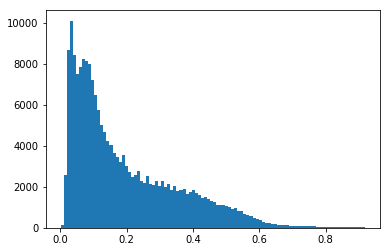

In [289]:
plt.hist(integral_x, bins=100);

In [290]:
lmaxs = [10,30,100,300]

integral = np.zeros((len(lmaxs), len(data['k'])))
for j in tqdm.tqdm_notebook(range(len(lmaxs))):
    alm_map = hp.map2alm(x, lmax=lmaxs[j])
    _map = hp.alm2map(alm_map, nside, verbose=False)

    int_points = np.linspace(0,1,200)
    for ii in range(len(int_points)):
        integral[j] += np.exp(lnbinomial(int_points[ii]/(1+np.exp(-_map)), data['k'], data['n']))
        integral[j] *= 1/(len(int_points)*(1+np.exp(-_map)))

/home/andy/py3/lib/python3.5/site-packages/ipykernel_launcher.py:3: RuntimeWarning: divide by zero encountered in log
  This is separate from the ipykernel package so we can avoid doing imports until
/home/andy/py3/lib/python3.5/site-packages/ipykernel_launcher.py:3: RuntimeWarning: invalid value encountered in multiply
  This is separate from the ipykernel package so we can avoid doing imports until


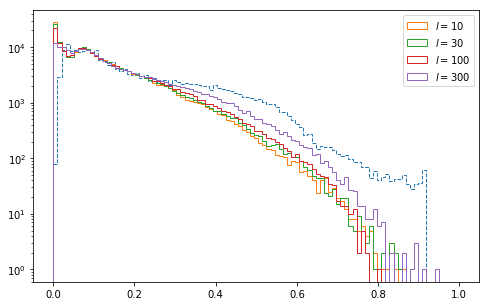

In [291]:
plt.figure(figsize=(8,5))

bins=np.linspace(0,1,100)
plt.hist(integral_x, bins=bins, linestyle='--', histtype='step');
for j in range(len(lmaxs)):
    plt.hist(integral[j], bins=bins, histtype='step', label=r'$l=%d$'%lmaxs[j]);
plt.legend()
plt.yscale('log')

In [126]:
x_n=1
x_k=1
x_nk=1
comb_grid = np.zeros((np.max(data['n'].astype(int))+1, np.max(data['n'].astype(int))+1)).astype(np.int64)
for i in tqdm.tqdm_notebook(range(1,np.max(data['n'].astype(int))+1)):
    x_k=1
    x_nk=x_n
    for j in range(i):
        try:
            comb_grid[i,j] = x_k/(x_n*x_nk)
        except OverflowError:
            print(i)
            print(x)
            break
        x_k*=j
        x_nk = x_nk//(i-j)
    x_n *= i+1

KeyboardInterrupt: 

In [138]:
from numba import njitit

In [171]:
@njit
def get_comb(comb_grid, max_n):
    
    x_n=1
    for i in range(1,max_n+1):
        x_k=1
        x_nk=x_n
        for j in range(i):
            print(x_nk)
            comb_grid[i,j] = x_k/(x_n*x_nk)

            x_k*=j
            x_nk = x_nk//(i-j)
        x_n *= i+1
        
    return comb_grid

In [172]:
max_n = 50#np.max(data['n'].astype(int))
comb_grid = np.zeros((max_n+1, max_n+1)).astype(np.int64)

In [173]:
%time get_comb(comb_grid, max_n)

1
2
1
6
2
1
24
6
2
1
120
24
6
2
1
720
120
24
6
2
1
5040
720
120
24
6
2
1
40320
5040
720
120
24
6
2
1
362880
40320
5040
720
120
24
6
2
1
3628800
362880
40320
5040
720
120
24
6
2
1
39916800
3628800
362880
40320
5040
720
120
24
6
2
1
479001600
39916800
3628800
362880
40320
5040
720
120
24
6
2
1
6227020800
479001600
39916800
3628800
362880
40320
5040
720
120
24
6
2
1
87178291200
6227020800
479001600
39916800
3628800
362880
40320
5040
720
120
24
6
2
1
1307674368000
87178291200
6227020800
479001600
39916800
3628800
362880
40320
5040
720
120
24
6
2
1
20922789888000
1307674368000
87178291200
6227020800
479001600
39916800
3628800
362880
40320
5040
720
120
24
6
2
1
355687428096000
20922789888000
1307674368000
87178291200
6227020800
479001600
39916800
3628800
362880
40320
5040
720
120
24
6
2
1
6402373705728000
355687428096000
20922789888000
1307674368000
87178291200
6227020800
479001600
39916800
3628800
362880
40320
5040
720
120
24
6
2
1
121645100408832000
6402373705728000
355687428096000
2092278

ZeroDivisionError: division by zero

In [137]:
%time get_comb(comb_grid, max_n)

CPU times: user 632 ms, sys: 56 ms, total: 688 ms
Wall time: 688 ms


array([[0, 0, 0, ..., 0, 0, 0],
       [1, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]])

In [115]:
np.math.factorial(21)

51090942171709440000

In [111]:
np.int64

numpy.int64

In [15]:
scipy.misc.comb(10,3)

AttributeError: module 'scipy.misc' has no attribute 'comb'

In [91]:
%timeit scipy.integrate.quad(integrand, 0, 0.5)

29.8 µs ± 836 ns per loop (mean ± std. dev. of 7 runs, 10000 loops each)


In [93]:
30*200000 / 1e6

6.0

In [42]:
np.math.factorial(k)/(np.math.factorial(n+1)*np.math.factorial(n-k))

0.000462962962962963

In [43]:
np.math.factorial(k)/(np.math.factorial(n)*np.math.factorial(n-k))

0.002777777777777778

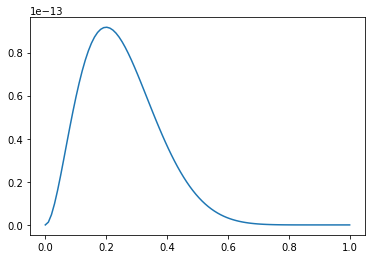

In [22]:
x = np.linspace(0,1,100)
plt.plot(x, binomial(x, 2, 10))
#plt.yscale('log')